In [1]:
import sys
import torch
from PIL import Image
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from concurrent.futures import ThreadPoolExecutor
from torchvision import transforms


In [59]:
# Video loading and frame preprocessing
def load_video_frames(video_path, num_frames=16):
    # Read the video file
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(
        0, total_frames - 1, num_frames, dtype=int)  # Sample evenly

    for idx in frame_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)  # Go to the specific frame
        success, frame = cap.read()
        if not success:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frames.append(frame)

    cap.release()
    
    # crop face from images
    frames = cropFace(frames)

    # Crop eyes from the detected faces
    frames = cropEyeRegion(frames)

    return frames


def cropFace(frames):
    """Crop the most prominent face from each frame in a list of frames.
    
    Args:
        frames (list): List of frames (numpy arrays) in RGB format.
    
    Returns:
        list: List of cropped face frames. If no face is detected, returns the original frame.
    """
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    cropped_faces = []

    for frame in frames:
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert frame to grayscale
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        if len(faces) > 0:
            # Find the largest face by area (w * h)
            largest_face = max(faces, key=lambda f: f[2] * f[3])  # Selects face with max width * height

            # Extract the largest face
            x, y, w, h = largest_face
            face = frame[y:y+h, x:x+w]
            face = cv2.resize(face, (224, 224))  # Resize to 224x224
            cropped_faces.append(face)
        else:
            cropped_faces.append(frame)  # If no face detected, keep original frame
            
    return cropped_faces

def cropEyeRegion(faces):
    """
    Crop a region that includes both eyes, the nose bridge, and brows.

    Args:
        faces (list): List of cropped face images.

    Returns:
        list: List of cropped eye-brow-nose bridge region frames.
    """
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
    cropped_eye_regions = []

    for face in faces:
        gray = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(20, 20))

        if len(eyes) >= 2:
            # Sort by x-coordinate to ensure left eye comes first
            eyes = sorted(eyes, key=lambda e: e[0])
            
            # Extract left and right eyes
            x1, y1, w1, h1 = eyes[0]  # Left eye
            x2, y2, w2, h2 = eyes[1]  # Right eye

            # Define a region covering both eyes, eyebrows, and nose bridge
            x_start = min(x1, x2) - 10
            y_start = min(y1, y2) - int(h1 * 0)  # Extend upwards to include eyebrows
            x_end = max(x1 + w1, x2 + w2) + 10
            y_end = max(y1 + h1, y2 + h2) + int(h1 * 0)  # Extend downwards to include nose bridge

            # Ensure the cropped region is within image boundaries
            x_start = max(0, x_start)
            y_start = max(0, y_start)
            x_end = min(face.shape[1], x_end)
            y_end = min(face.shape[0], y_end)

            eye_region = face[y_start:y_end, x_start:x_end]
            eye_region = cv2.resize(eye_region, (224, 224))  # Resize for consistency
            cropped_eye_regions.append(eye_region)
        else:
            cropped_eye_regions.append(face)  # If no eyes detected, keep full face

    return cropped_eye_regions

In [60]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels_df):
        self.video_paths = []
        self.labels = []

        for person in os.listdir(video_paths):
            person_path = os.path.join(video_paths, person)
            if not os.path.isdir(person_path):
                continue  # Skip if it's not a directory

            for video in os.listdir(person_path):
                video_path = os.path.join(person_path, video)
                if not os.path.isdir(video_path):
                    continue  # Skip if it's not a directory

                for filename in os.listdir(video_path):
                    if filename.endswith(".mp4") or filename.endswith(".avi"):
                        if filename in labels_df["ClipID"].values:   
                            self.video_paths.append(
                                os.path.join(video_path, filename))
                            self.labels.append(
                                labels_df.loc[labels_df["ClipID"] == filename, "Engagement"].values[0])
                            # print(f"Found video: {os.path.join(video_path, filename)}")
                        
        # **Parallel Processing for Video Preprocessing**
        self.processed_videos = [None] * len(self.video_paths)  # Placeholder for preprocessed videos
        with ThreadPoolExecutor(max_workers=4) as executor:
            self.processed_videos = list(executor.map(self.load_and_preprocess_video, self.video_paths))
            
        print(f"Loaded {len(self.video_paths)} videos")
            
    def load_and_preprocess_video(self, video_path):
        """Loads and preprocesses a single video."""
        video_frames = load_video_frames(video_path)
        return video_frames

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        return self.processed_videos[idx], self.labels[idx]

In [61]:
# Define the video and labels path
video_paths = "dataset/DAiSEE/DAiSEE/DataSet/Train/"
label_path = "dataset/DAiSEE/DAiSEE/Labels/AllLabels.csv"
val_video_paths = "dataset/DAiSEE/DAiSEE/DataSet/Validation/"

labels_df = pd.read_csv(label_path)

# Drop the other classification columns
labels_df = labels_df.drop(columns=["Boredom", "Confusion", "Frustration "])
labels_df.head()

,ClipID,Engagement
0,1100011002.avi,2
1,1100011003.avi,2
2,1100011004.avi,3
3,1100011005.avi,3
4,1100011006.avi,3


In [62]:
# Determine the minimum class count
min_samples = labels_df["Engagement"].value_counts().min()

# Undersample each class to have the same number of samples
balanced_labels_df = labels_df.groupby("Engagement").apply(lambda x: x.sample(n=min_samples, random_state=42)).reset_index(drop=True)

print(balanced_labels_df.shape)

(244, 2)


/tmp/ipykernel_1552335/3940651049.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_labels_df = labels_df.groupby("Engagement").apply(lambda x: x.sample(n=min_samples, random_state=42)).reset_index(drop=True)


In [63]:
# load and preprocess the data
train_dataset = VideoDataset(video_paths, balanced_labels_df)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)

Loaded 144 videos


In [64]:
# # load and preprocess the validation data
# val_dataset = VideoDataset(val_video_paths, labels_df)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, drop_last=True)

In [65]:
def tensor_to_image(tensor):
    """
    Convert a tensor (processed with `load_video_frames`) back to an image and display it.
    
    Args:
        tensor (torch.Tensor): A tensor of shape (3, 224, 224).
    
    Returns:
        None (Displays the image).
    """
    # Ensure the tensor is detached and moved to CPU
    # tensor = tensor.cpu().detach()

    # image = tensor  # No normalization applied in `load_video_frames`

    # # mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)  # Mean used during normalization
    # # std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)   # Std deviation used during normalization
    # # image = tensor * std + mean  # Unnormalize
    
    # # Convert from (C, H, W) to (H, W, C) and scale values to 0-255
    # image = image.permute(1, 2, 0).numpy()  # Convert to NumPy (H, W, C)
    # image = (image * 255).astype(np.uint8)  # Scale back to 0-255

    # Display the image
    plt.imshow(image)
    plt.axis("off")
    plt.show()


In [66]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def display_dataloader_images(dataloader, num_images=5):
    """
    Display a few images from the dataloader.

    Args:
        dataloader: The PyTorch DataLoader containing video frame batches.
        num_images: Number of images to display from the batch.

    Returns:
        None (Displays images using matplotlib).
    """
    # Get a batch from the dataloader
    for video_frames_batch, labels_batch in dataloader:

        # Select the first video in the batch
        video_frames = video_frames_batch[0]  # Shape: (num_frames, 3, 224, 224)
        num_frames = min(num_images, video_frames.shape[0])  # Limit number of images to display

        # Create a figure
        fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))

        for i in range(num_frames):
            frame = video_frames[i]  # Shape: (3, 224, 224)

            # Ensure correct format for matplotlib (H, W, C)
            # frame = frame.permute(1, 2, 0).numpy()  # Convert to (224, 224, 3)
            frame = frame.numpy()
            # frame = np.clip(frame * 255, 0, 255).astype(np.uint8)  # Scale to 0-255

            axes[i].imshow(frame)
            axes[i].axis("off")
            axes[i].set_title(f"Frame {i+1}")

        plt.show()
        break

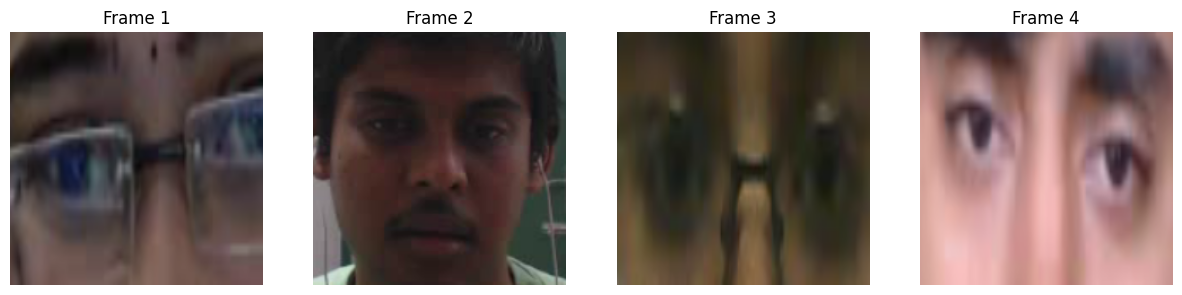

In [85]:
display_dataloader_images(train_loader)